# Setup

In [1]:
import importlib
import os

import joblib
import pandas as pd

import tlp

base_url = 'https://snap.stanford.edu/data/'
file_name = 'act-mooc.tar.gz'
dataset_id = '31'
adjusted_intervals = dict()

# Download and extract data

In [25]:
import tarfile

os.makedirs(dataset_id, exist_ok=True)
edgelist_location = f'{dataset_id}/edgelist.pkl'
download_location = os.path.join(dataset_id, file_name)
if not os.path.isfile(edgelist_location):
  if not os.path.isfile(download_location):
    tlp.download_from_url(os.path.join(base_url, file_name), 
                          download_location, verbose=True)
    
  if not os.path.isdir(os.path.join(dataset_id, 'act-mooc')):
    with tarfile.open(download_location, "r:gz") as tar:
      tar.extractall(dataset_id)
  
  df = pd.read_csv(
    os.path.join(dataset_id, 'act-mooc', 'mooc_actions.tsv'), 
    delim_whitespace=True)
  df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], unit='s')
  df = df.rename(
    columns={'USERID': 'source', 'TARGETID': 'target', 'TIMESTAMP': 'datetime'})
  df.to_pickle(edgelist_location)

# Splitting

In [26]:
%%time
filepath_edgelist = f'{dataset_id}/edgelist.pkl'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'

if not os.path.isfile(filepath_mature) or not os.path.isfile(filepath_probe):
  edgelist_mature, edgelist_probe = tlp.split_in_intervals(
    edgelist=joblib.load(filepath_edgelist), **adjusted_intervals)
  joblib.dump(edgelist_mature, filepath_mature)
  joblib.dump(edgelist_probe, filepath_probe)

CPU times: user 20.4 ms, sys: 25.7 ms, total: 46.1 ms
Wall time: 99.9 ms


# Instances

In [27]:
%%time
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances = f'{dataset_id}/instances.pkl'

if not os.path.isfile(filepath_instances):
  instances = tlp.get_instances(edgelist_mature=joblib.load(filepath_mature),
    verbose=True)
  joblib.dump(instances, filepath_instances)

CPU times: user 1min 32s, sys: 2.32 s, total: 1min 34s
Wall time: 1min 34s


# Targets

In [28]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'
filepath_targets = f'{dataset_id}/targets.pkl'

if not os.path.isfile(filepath_targets):
  targets = tlp.get_targets(
    instances=joblib.load(filepath_instances),
    edgelist_probe=joblib.load(filepath_probe),
    verbose=True)
  joblib.dump(targets, filepath_targets)

Determine targets:   0%|          | 0/20535296 [00:00<?, ?it/s]

CPU times: user 27.9 s, sys: 629 ms, total: 28.5 s
Wall time: 28.4 s


# Sampling

In [29]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_targets = f'{dataset_id}/edgelist_targets.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'
filepath_targets_sampled = f'{dataset_id}/targets_sampled.pkl'

if not (os.path.isfile(filepath_instances_sampled) and 
        os.path.isfile(filepath_targets_sampled)):
  instances_sampled, targets_sampled = tlp.balanced_sample(instances, targets)
  joblib.dump(instances_sampled, f'{dataset_id}/instances_sampled.pkl')
  joblib.dump(targets_sampled, f'{dataset_id}/targets_sampled.pkl')

CPU times: user 392 ms, sys: 35.9 ms, total: 428 ms
Wall time: 449 ms


# Features

## AA (time agnostic)

In [30]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_agnostic = tlp.features.adamic_adar_time_agnostic(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath)

CPU times: user 18.3 s, sys: 19.1 ms, total: 18.3 s
Wall time: 18.3 s


## AA (time aware)

In [31]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_aware = tlp.features.adamic_adar_time_aware(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath,
  verbose=True)

time strategies:   0%|          | 0/3 [00:00<?, ?it/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

CPU times: user 25min 25s, sys: 17.6 s, total: 25min 42s
Wall time: 25min 32s


# Analysis

## Figure: Edge distribution with maturing and probing intervals indicated

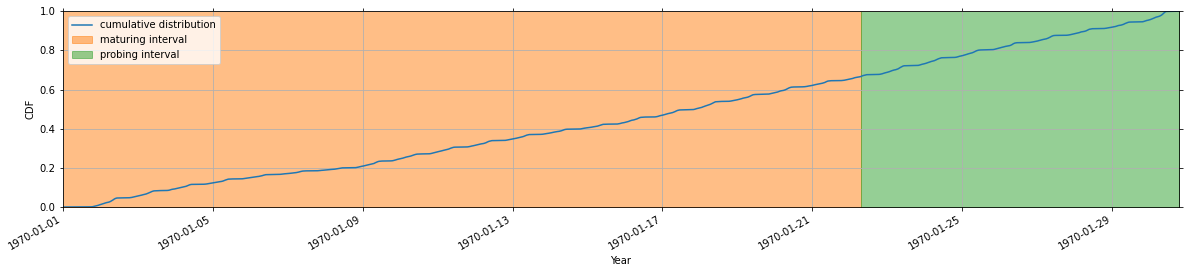

In [32]:
tlp.analysis.plot_datetime(
  joblib.load(f'{dataset_id}/edgelist.pkl')['datetime'], **adjusted_intervals)

## Metric: Class imbalance

In [33]:
tlp.analysis.class_imbalance(targets=joblib.load(f'{dataset_id}/targets.pkl'))

,absolute,relative
False,20535018,0.999986
True,278,0.000014


## Figure: Datetime strategies

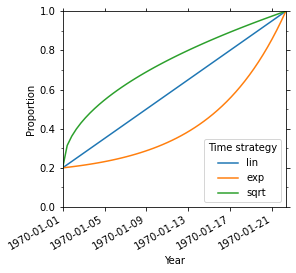

In [34]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
t = tlp.analysis.plot_datetime_strategies(edgelist['datetime'])

## Figure: Datetime distribution

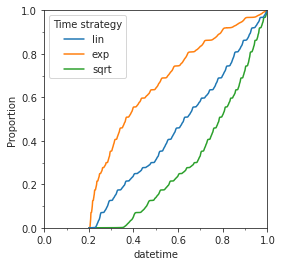

In [35]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
tlp.analysis.plot_datetime_distribution(edgelist['datetime'])

## Figure: Scores

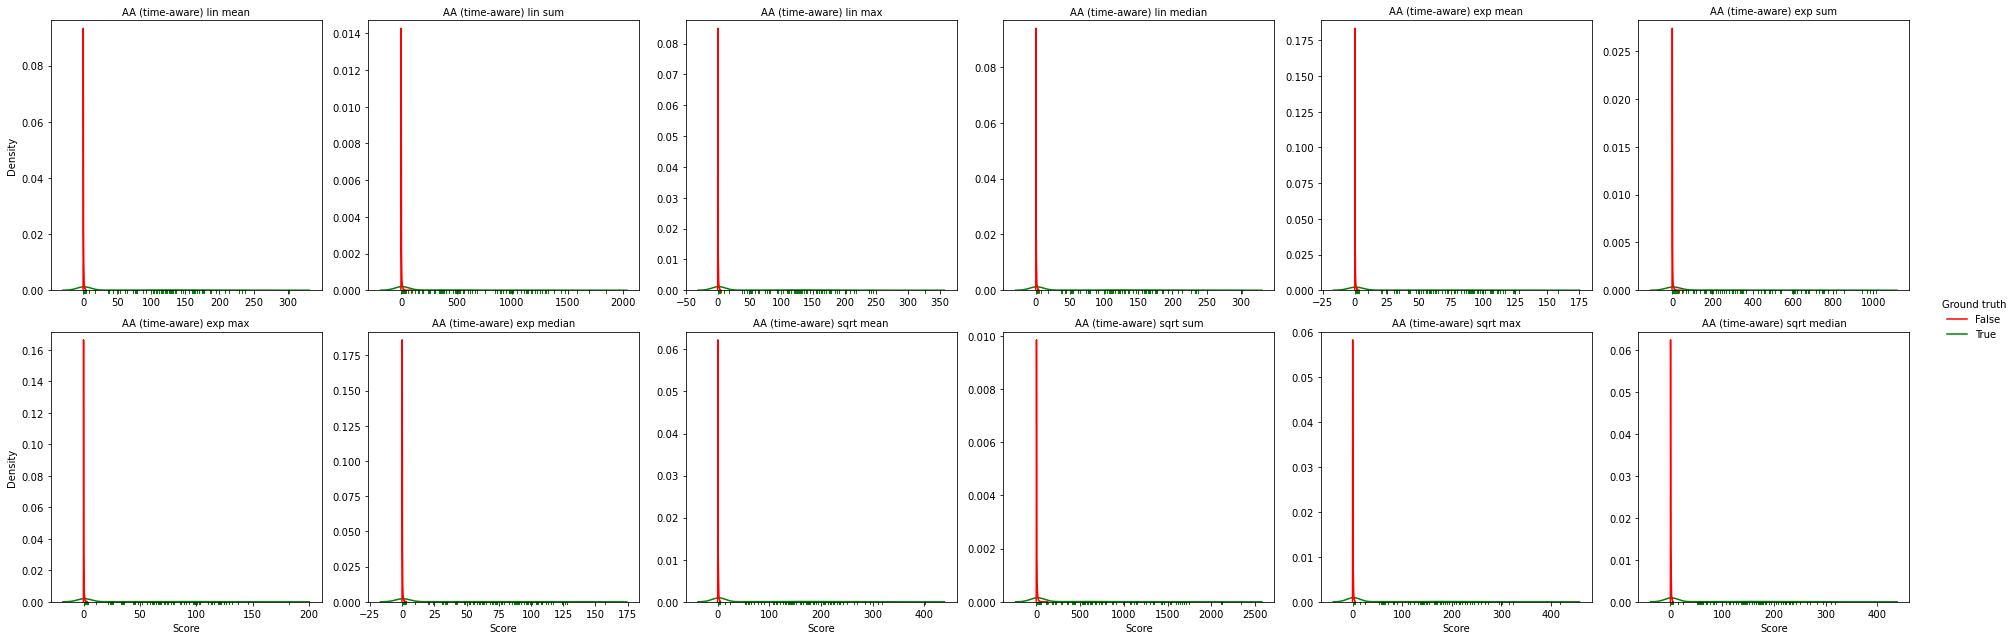

In [36]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_score(feature_dict, targets)

## Figure: ROC

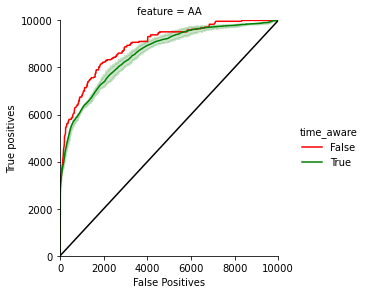

In [37]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_roc_auc(feature_dict, targets)

## AUC

In [38]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  for file in os.scandir(f'{dataset_id}/features'):
    if file.is_file():
      feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.get_auc(feature_dict, targets)

feature  time_aware  aggregation_strategy  time_strategy
AA       False       NaN                   NaN              0.893570
         True        mean                  lin              0.849971
                     sum                   lin              0.875146
                     max                   lin              0.863644
                     median                lin              0.849023
                     mean                  exp              0.860005
                     sum                   exp              0.883091
                     max                   exp              0.869222
                     median                exp              0.859245
                     mean                  sqrt             0.853336
                     sum                   sqrt             0.880655
                     max                   sqrt             0.866231
                     median                sqrt             0.853234
Name: auc, dtype: float64